In [ ]:
#!pip install -U scikit-learn
#!pip install numpy
#!pip install --user -U nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#!pip install unidecode
#!pip install matplotlib

In [1]:
import pandas as pd
import nltk
import time
import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import RSLPStemmer
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#Carrega dados refined
df = pd.read_csv("../s3_data/refined/refined.csv", names=["wiki_id", "title", "timestamp", "user","bot"])

## Parte 1
## Pré Processamento

In [3]:
#Remove linhas com dados nulos, transformando em minusculo e removendo aspas simples
df["title"].dropna(inplace=True)
df["bot"].dropna(inplace=True)
df["user"] = df["user"].replace({'\'': ''}, regex=True)
lw_text = df["title"].str.lower()
lw_text = lw_text.replace({'\'': ''}, regex=True)
df["user"] = df["user"].str.strip().replace({'^[0-9]*$': 'unknown'}, regex=True)

In [4]:
#Normalizando timestamp
s = "01/01/2020"
default_timestamp = int(datetime.datetime.strptime('01/01/2020', '%d/%m/%Y').strftime("%s"))
df["timestamp"] = df["timestamp"].str.strip().replace({'^((?![0-9]).)*$': default_timestamp}, regex=True)

In [5]:
#Substitui valores diferentes de booleano pela item de maior frequencia
max_freq = df.bot.mode()[0]
df["bot"] = df["bot"].str.strip().replace({'^((?!(False|True)).)*$': max_freq.strip()}, regex=True)
#df["bot"] = df["bot"].astype(bool)

In [6]:
#Cria os tokens dos titulos
tokens =  lw_text.apply(word_tokenize)

In [7]:
#Normalizando com unicode
tokens_uni = tokens.apply(lambda x: [unidecode(z) for z in x ])

In [8]:
#Remove stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords.extend(['categoria','artigos', 'predefinicao','ficheiro','sobre','predefinicoes','redirecionamentos','esbocos','ligados','elemento','inexistentes','ficheiros','usuario','wikidata','paginas','wikipedia','discussao','lista'])
stopwords = set(stopwords + list(punctuation))
title_cleaned = tokens_uni.apply(lambda line:  [w for w in line if not w in stopwords])

In [9]:
#Cria coluna com os titulos tratados
df["title_cleaned"] = title_cleaned.apply(lambda line: " ".join(line))
df.head()

,wiki_id,title,timestamp,user,bot,title_cleaned
0,96937943,'Predefinição:Pandemia de COVID-19 na França',1587234893,Francisco Leandro,False,pandemia covid-19 franca
1,96937944,'Categoria:!Predefinições sobre a pandemia de...,1587234893,Francisco Leandro,False,pandemia covid-19 franca
2,96937945,'Categoria:!Predefinições sobre a pandemia de...,1587234893,Francisco Leandro,False,pandemia covid-19
3,96937946,'Pandemia de COVID-19 na Espanha',1587234902,Raimundo57br,False,pandemia covid-19 espanha
4,96937947,'Campo de Marte (Roma)',1577847600,unknown,False,campo marte roma


In [31]:
df.isna().sum()

wiki_id          0
title            0
timestamp        0
user             0
bot              0
title_cleaned    0
title_stemmed    0
dtype: int64

In [10]:
#Cria coluna com os titulos com steamming
def Stemming(sentence):
    stemmer = RSLPStemmer()
    phrase = []
    for word in sentence:
        phrase.append(stemmer.stem(word.lower()))
    return phrase

stemmed_list = title_cleaned.apply(lambda line: Stemming(line))
df["title_stemmed"] = stemmed_list.apply(lambda line: " ".join(line))
df.head()

,wiki_id,title,timestamp,user,bot,title_cleaned,title_stemmed
0,96937943,'Predefinição:Pandemia de COVID-19 na França',1587234893,Francisco Leandro,False,pandemia covid-19 franca,pandem covid-19 franc
1,96937944,'Categoria:!Predefinições sobre a pandemia de...,1587234893,Francisco Leandro,False,pandemia covid-19 franca,pandem covid-19 franc
2,96937945,'Categoria:!Predefinições sobre a pandemia de...,1587234893,Francisco Leandro,False,pandemia covid-19,pandem covid-19
3,96937946,'Pandemia de COVID-19 na Espanha',1587234902,Raimundo57br,False,pandemia covid-19 espanha,pandem covid-19 espanh
4,96937947,'Campo de Marte (Roma)',1577847600,unknown,False,campo marte roma,camp mart rom


In [11]:
# Separa dataframes entre bots true e false
title_bot_true = df[(df.bot == 'True')][["title","title_cleaned","title_stemmed"]]
title_bot_true.head()

,title,title_cleaned,title_stemmed
17,'Ryazan',ryazan,ryazan
29,'Usuário(a) Discussão:191.53.150.73',discussao:191.53.150.73,discussao:191.53.150.73
161,'Exército',exercito,exercit
182,'Resânia',resania,resan
241,'Categoria:!Redirecionamentos ligados a um el...,,


In [12]:
title_bot_false = df[(df.bot == 'False')][["title","title_cleaned","title_stemmed"]]
title_bot_false.head()

,title,title_cleaned,title_stemmed
0,'Predefinição:Pandemia de COVID-19 na França',pandemia covid-19 franca,pandem covid-19 franc
1,'Categoria:!Predefinições sobre a pandemia de...,pandemia covid-19 franca,pandem covid-19 franc
2,'Categoria:!Predefinições sobre a pandemia de...,pandemia covid-19,pandem covid-19
3,'Pandemia de COVID-19 na Espanha',pandemia covid-19 espanha,pandem covid-19 espanh
4,'Campo de Marte (Roma)',campo marte roma,camp mart rom


In [29]:
# Vec. transform com bots = true
str_list = title_bot_true["title_stemmed"].values
vec = TfidfVectorizer()
vec.fit(str_list)
features_bot_true = vec.transform(str_list)
print(features_bot_true)

  (0, 601)	1.0
  (1, 315)	0.2768663476571901
  (1, 134)	0.4948634424337313
  (1, 109)	0.4948634424337313
  (1, 40)	0.46559927632044384
  (1, 20)	0.46559927632044384
  (2, 364)	1.0
  (3, 589)	1.0
  (5, 674)	0.47983491159260516
  (5, 574)	0.4684009376408448
  (5, 538)	0.4204823754474598
  (5, 278)	0.21460210931566748
  (5, 257)	0.39433327479266306
  (5, 237)	0.35522214464015245
  (5, 39)	0.21405144754933716
  (6, 315)	0.26939786774438834
  (6, 50)	0.48151448287013576
  (6, 26)	0.48151448287013576
  (6, 22)	0.48151448287013576
  (6, 4)	0.48151448287013576
  (10, 554)	0.5114305784179488
  (10, 293)	0.5142906992661592
  (10, 278)	0.48742257039420367
  (10, 39)	0.48617186053669836
  (11, 538)	0.5667933589162981
  :	:
  (692, 330)	0.41787351337496026
  (692, 315)	0.23379199898423755
  (692, 146)	0.41787351337496026
  (692, 141)	0.41787351337496026
  (692, 122)	0.41787351337496026
  (692, 81)	0.30379546397716845
  (692, 33)	0.39316221150629277
  (693, 315)	0.2768663476571901
  (693, 158)	0.465

In [30]:
# Vec. transform com bots = false
str_list = title_bot_false["title_stemmed"].values
vec.fit(str_list)
features_bot_false = vec.transform(str_list)
print(features_bot_false)

  (0, 7366)	0.49508651772608114
  (0, 4641)	0.5571268659648859
  (0, 3229)	0.4743590954229548
  (0, 212)	0.4684895343287008
  (1, 7366)	0.49508651772608114
  (1, 4641)	0.5571268659648859
  (1, 3229)	0.4743590954229548
  (1, 212)	0.4684895343287008
  (2, 7366)	0.5961827871243295
  (2, 3229)	0.5712228418296409
  (2, 212)	0.5641547210728058
  (3, 7366)	0.4717430666493176
  (3, 4150)	0.6114636307661235
  (3, 3229)	0.45199294740567014
  (3, 212)	0.4464001375606222
  (4, 8185)	0.6412297273209235
  (4, 6450)	0.5778154394524782
  (4, 2589)	0.5049294552016881
  (5, 6322)	0.7071067811865475
  (5, 2063)	0.7071067811865475
  (6, 7366)	0.5249421394328267
  (6, 3229)	0.5029647738226591
  (6, 2365)	0.4740361921974699
  (6, 212)	0.4967412556131527
  (7, 9751)	0.6407762126376942
  :	:
  (23312, 4711)	0.34725811366800097
  (23312, 4019)	0.629292946157741
  (23312, 2992)	0.33269334574441795
  (23313, 4711)	0.33477437107351726
  (23313, 4691)	0.5470930226720634
  (23313, 2992)	0.3207331987307138
  (23313,

## Parte 2
## Artigos alterados por bot x não bots

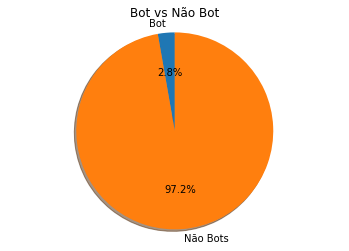

In [25]:
import matplotlib.pyplot as plt

labels = 'Bot','Não Bots'
data = [features_bot_true.size, features_bot_false.size]

fig1, ax1 = plt.subplots()

ax1.pie(data, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

ax1.axis('equal')
ax1.set_title("Bot vs Não Bot")
plt.show()

## Palavras mais populares

            Frequency
Word                 
covid-19          141
pandemia          136
dados             134
futebol            29
campeonato         21
alagoano           21
pagina             19
casos              18
russia             17
resultados         17


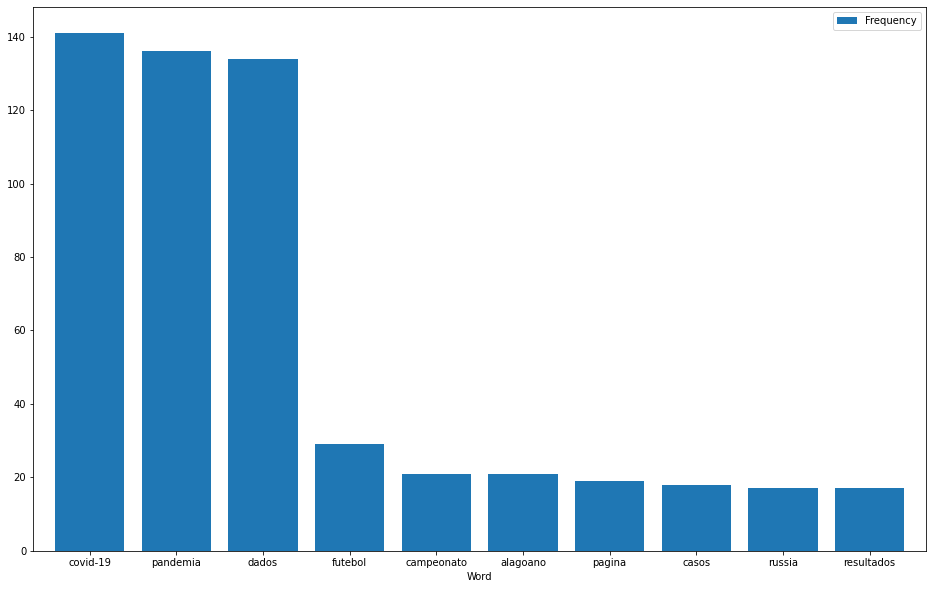

In [15]:
#bot = true
from collections import Counter
top_N = 10
words = title_bot_true["title_cleaned"].str.cat(sep=' ').split()
rslt = pd.DataFrame(Counter(words).most_common(top_N), columns=['Word', 'Frequency']).set_index('Word')
print(rslt)
rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

            Frequency
Word                 
carecem           779
capas             661
albuns            643
futebol           566
2020              564
sao               491
abril             490
eliminacao        486
paulo             460
desde             444


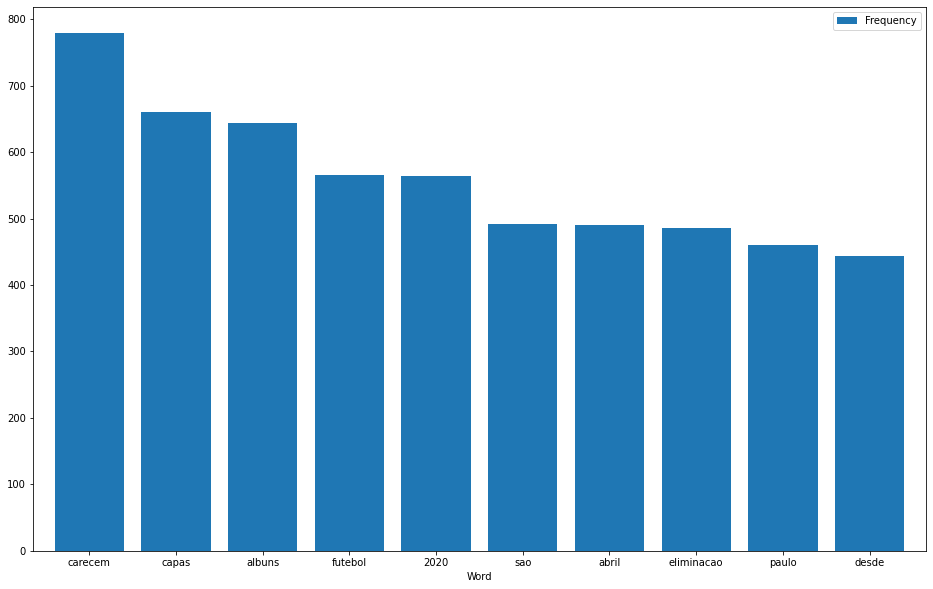

In [16]:
#bot = false
from collections import Counter
top_N = 10
words = title_bot_false["title_cleaned"].str.cat(sep=' ').split()
rslt = pd.DataFrame(Counter(words).most_common(top_N), columns=['Word', 'Frequency']).set_index('Word')
print(rslt)
rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

## K-Means bot = false

In [17]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,150)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_bot_false)
    Sum_of_squared_distances.append(km.inertia_)



KeyboardInterrupt: 

In [ ]:
#Best result cluster = 150
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Uma forma de se julgar esses números, é analisar a técnica do cotovelo. Nela, procura-se o número de clusters que faz com que o ganho se torne marginal. Como nossa curva se aproxima de uma reta, não é possível visualmente escolher qualquer número de clusters (para o nossa caso, tratando de textos).

Dessa forma, considerando que processamentos de texto lidam com milhares de dimensões em uma mesma análise, já era esperado que os resultados sofressem dessa maldição.

Isso, porém, não significa que os clusters não sejam relevantes ou tenham qualquer prejuízo interpretativo. Na prática, a maldição da dimensionalidade implica apenas que é necessário input humano para decidir o melhor número de clusters.

In [ ]:
from sklearn.decomposition import PCA

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1)

#Visualização gráfica 2D     # Converte as features para 2D     
pca = PCA(n_components=2, random_state= 0)
reduced_features = pca.fit_transform(features_bot_false.toarray())

# Converte os centros dos clusters para 2D     
reduced_cluster_centers = pca.transform(km.cluster_centers_)

#Plota gráfico 2D     
ax.scatter(reduced_features[:,0], reduced_features[:,1], c=km.predict(features_bot_false))
ax.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='o', s=150, edgecolor='k')

#Plota números nos clusters     
for i, c in enumerate(reduced_cluster_centers):
    ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

cluster=5
#Adiciona informações no gráfico     
plt.title("Análise de cluster k = %d" % cluster)
plt.xlabel('Dispersão em X')
plt.ylabel('Dispersão em Y')



#Visualização gráfica 3D 

ax = fig.add_subplot(1, 2, 2,projection="3d")

# ax = plt.axes(projection="3d") 
# Adiciona informações no gráfico     
plt.title("Análise de cluster k = %d" % cluster)
plt.xlabel('Dispersão em X')
plt.ylabel('Dispersão em Y')

#converte dados para 3D     
pca = PCA(n_components=3, random_state=0)
reduced_features = pca.fit_transform(features_bot_false.toarray())

#Plota dados em 3D     
ax.scatter3D(reduced_features[:,0], reduced_features[:,1], reduced_features[:,2], marker='o', s=150, edgecolor='k', c=km.predict(features_bot_false))

# Converte os centros dos clusters para 3D     
reduced_cluster_centers = pca.transform(km.cluster_centers_)

#Salva arquivo de imagem 3D     
plt.savefig("imagens/grafico_cluster_k=%d" % cluster)
plt.show()

## K-means bot = True

In [26]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_bot_true)
    Sum_of_squared_distances.append(km.inertia_)

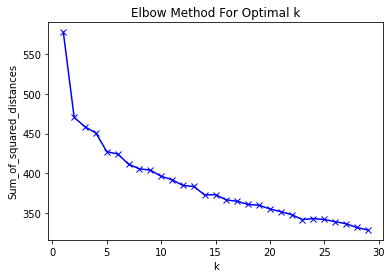

In [27]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

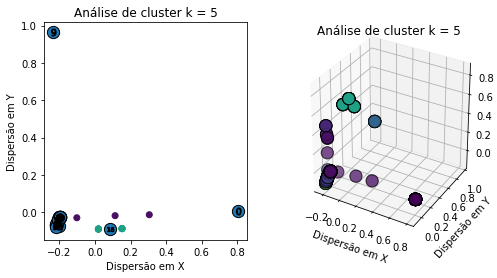

In [28]:
from sklearn.decomposition import PCA

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1)

#Visualização gráfica 2D     # Converte as features para 2D     
pca = PCA(n_components=2, random_state= 0)
reduced_features = pca.fit_transform(features_bot_true.toarray())

# Converte os centros dos clusters para 2D     
reduced_cluster_centers = pca.transform(km.cluster_centers_)

#Plota gráfico 2D     
ax.scatter(reduced_features[:,0], reduced_features[:,1], c=km.predict(features_bot_true))
ax.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='o', s=150, edgecolor='k')

#Plota números nos clusters     
for i, c in enumerate(reduced_cluster_centers):
    ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

cluster=5
#Adiciona informações no gráfico     
plt.title("Análise de cluster k = %d" % cluster)
plt.xlabel('Dispersão em X')
plt.ylabel('Dispersão em Y')



#Visualização gráfica 3D 

ax = fig.add_subplot(1, 2, 2,projection="3d")

# ax = plt.axes(projection="3d") 
# Adiciona informações no gráfico     
plt.title("Análise de cluster k = %d" % cluster)
plt.xlabel('Dispersão em X')
plt.ylabel('Dispersão em Y')

#converte dados para 3D     
pca = PCA(n_components=3, random_state=0)
reduced_features = pca.fit_transform(features_bot_true.toarray())

#Plota dados em 3D     
ax.scatter3D(reduced_features[:,0], reduced_features[:,1], reduced_features[:,2], marker='o', s=150, edgecolor='k', c=km.predict(features_bot_true))

# Converte os centros dos clusters para 3D     
reduced_cluster_centers = pca.transform(km.cluster_centers_)

#Salva arquivo de imagem 3D     
plt.savefig("imagens/grafico_cluster_k=%d" % cluster)
plt.show()

## DBScan

In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
  
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 

In [22]:
X_normalized = pd.DataFrame(features_bot_true)

pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
print(X_principal.head()) 

ValueError: setting an array element with a sequence.